<a href="https://colab.research.google.com/github/AltagiAbdallah/Optimizing-Marketing-Spend-with-Customer-Sentiment-Analysis/blob/main/Optimizing_Marketing_Spend_with_Customer_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Getting the Amazon product reviews from kaggle**

In [1]:
import kagglehub
path = kagglehub.dataset_download("arhamrumi/amazon-product-reviews")

100%|██████████| 115M/115M [00:00<00:00, 136MB/s]

Extracting files...


**Step 0: Ingestion**

In [4]:
import pandas as pd
import os
import glob

csv_files = glob.glob(os.path.join(path, '*.csv'))

if csv_files:
    df_path = csv_files[0]
    df = pd.read_csv(df_path)
else:
    print("No CSV file found in the downloaded dataset directory.")
    df = pd.DataFrame()

print("--- FIRST 5 ROWS ---")
print(df.head())

print("\n--- DATASET INFO ---")
print(df.info())

print("\n--- MISSING VALUES ---")
print(df.isnull().sum())

--- FIRST 5 ROWS ---
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vita

**Step 1: Data Simulation**

We use this block to inject the marketing scenarios on the loded data.

In [16]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# ASSUMPTION: You have already loaded your Amazon dataset into 'df'
# Example: df = pd.read_csv('Reviews.csv')
# We sample up to 10,000 rows to keep things fast, or fewer if df is smaller
sample_size = min(10000, len(df)) # Ensure sample size does not exceed DataFrame length
df_subset = df.sample(n=sample_size, random_state=42).copy()

# --- DEFINE CAMPAIGN SCENARIOS ---
def assign_campaign_data(row):
    score = row['Score']

    # Logic: Bad reviews (1-2 stars) -> Likely from "Bad Influencer" Campaign
    if score <= 2:
        campaign_choice = np.random.choice(
            ['CAM-INFLUENCER', 'CAM-FB-PROMO', 'CAM-SEARCH'],
            p=[0.60, 0.10, 0.30]
        )
    # Logic: Good reviews (4-5 stars) -> Likely from "Good Facebook" Campaign
    elif score >= 4:
        campaign_choice = np.random.choice(
            ['CAM-INFLUENCER', 'CAM-FB-PROMO', 'CAM-SEARCH'],
            p=[0.10, 0.60, 0.30]
        )
    else:
        campaign_choice = np.random.choice(
            ['CAM-INFLUENCER', 'CAM-FB-PROMO', 'CAM-SEARCH'],
            p=[0.33, 0.33, 0.34]
        )

    # Assign Costs & Channels
    if campaign_choice == 'CAM-INFLUENCER':
        channel = 'TikTok/Instagram'
        spend = round(random.uniform(20.0, 50.0), 2) # Expensive
    elif campaign_choice == 'CAM-FB-PROMO':
        channel = 'Facebook Ads'
        spend = round(random.uniform(10.0, 25.0), 2) # Moderate
    else:
        channel = 'Google Search'
        spend = round(random.uniform(5.0, 15.0), 2)  # Cheap

    days_ago = random.randint(0, 90)
    simulated_date = datetime.now() - timedelta(days=days_ago)

    return pd.Series([campaign_choice, channel, spend, simulated_date.strftime('%Y-%m-%d')])

print("Injecting marketing data...")
df_subset[['Campaign_ID', 'Channel', 'Ad_Spend', 'Date']] = df_subset.apply(assign_campaign_data, axis=1)

# Cleanup
final_df = df_subset[['Date', 'Campaign_ID', 'Channel', 'Ad_Spend', 'Score', 'Review_Text']].copy()
print("Step 1 Complete: Dataset Ready.")

Injecting marketing data...
Step 1 Complete: Dataset Ready.


**Step 2: NLP Preprocessing & Text Visualization**

Here we clean the text AND visualize the most common words.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipython-input-3070680412.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


Cleaning text...


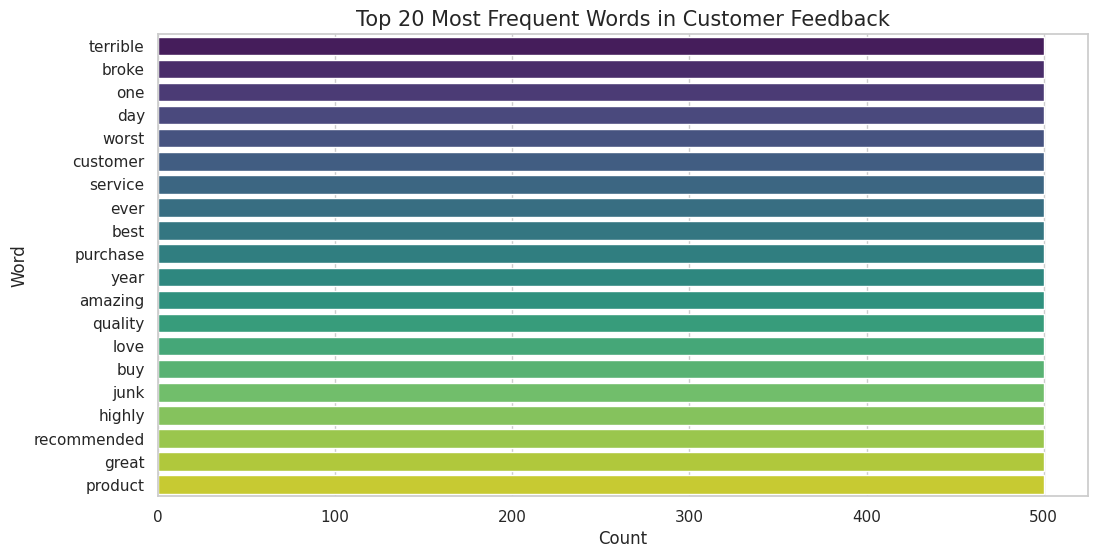

In [19]:
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Setup NLP Tools
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation
    words = text.split()
    clean_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(clean_words)

print("Cleaning text...")
final_df['Cleaned_Text'] = final_df['Review_Text'].apply(preprocess_text)

# --- NEW VISUAL 1: What are customers saying? ---
# We count the top 20 words across all reviews
all_words = ' '.join(final_df['Cleaned_Text']).split()
word_counts = Counter(all_words).most_common(20)
words_df = pd.DataFrame(word_counts, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Most Frequent Words in Customer Feedback', fontsize=15)
plt.xlabel('Count')
plt.show()

**Step 3: Sentiment Analysis & Distribution Check**

We apply VADER and then visualize the spread of sentiment to check if our campaigns look different.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Calculating sentiment...


/tmp/ipython-input-2642597928.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_df, x='Campaign_ID', y='Sentiment_Score', palette='coolwarm')


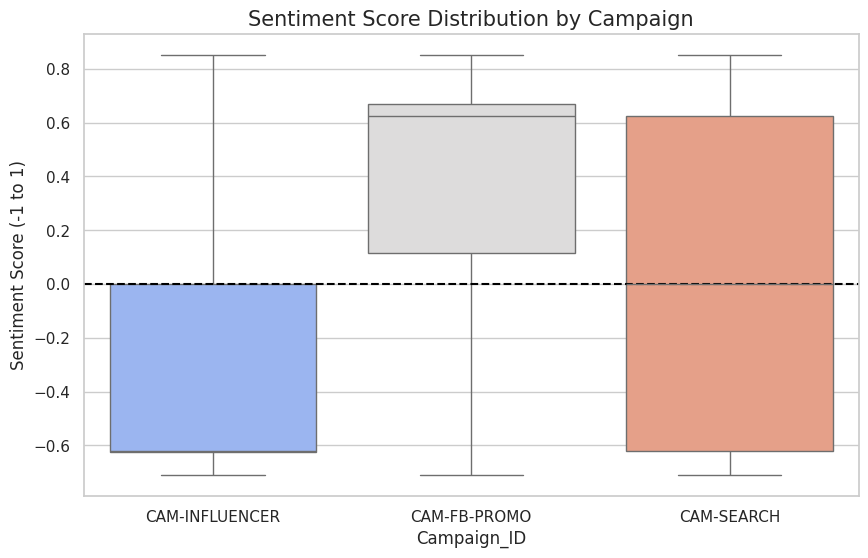

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Setup Sentiment Tool
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(str(text))['compound']

print("Calculating sentiment...")
final_df['Sentiment_Score'] = final_df['Review_Text'].apply(get_sentiment_score)

# Define Categories
def categorize_sentiment(score):
    if score >= 0.05: return 'Positive'
    elif score <= -0.05: return 'Negative'
    else: return 'Neutral'

final_df['Sentiment_Label'] = final_df['Sentiment_Score'].apply(categorize_sentiment)

# --- NEW VISUAL 2: Sentiment Distribution by Campaign ---
# This shows if one campaign is significantly "happier" than another
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='Campaign_ID', y='Sentiment_Score', palette='coolwarm')
plt.title('Sentiment Score Distribution by Campaign', fontsize=15)
plt.axhline(0, color='black', linestyle='--') # Neutral Line
plt.ylabel('Sentiment Score (-1 to 1)')
plt.show()

**Step 4: Business Aggregation (ROI Logic)**

We group the data to find the "Wasted Spend".

In [23]:
# Aggregate Data
campaign_performance = final_df.groupby('Campaign_ID').agg({
    'Ad_Spend': 'sum',
    'Sentiment_Score': 'mean',
    'Review_Text': 'count', # Changed 'Text' to 'Review_Text'
    'Sentiment_Label': lambda x: (x == 'Negative').sum()
}).reset_index()

campaign_performance.columns = ['Campaign_ID', 'Total_Spend', 'Average_Sentiment', 'Total_Reviews', 'Negative_Review_Count']

# Calculate KPIs
campaign_performance['Cost_Per_Review'] = campaign_performance['Total_Spend'] / campaign_performance['Total_Reviews']
campaign_performance['Negative_Ratio'] = campaign_performance['Negative_Review_Count'] / campaign_performance['Total_Reviews']
campaign_performance['Wasted_Spend_Est'] = campaign_performance['Total_Spend'] * campaign_performance['Negative_Ratio']

# Recommendations
def generate_recommendation(row):
    if row['Average_Sentiment'] < 0.2: return "STOP SPEND"
    elif row['Average_Sentiment'] > 0.6: return "SCALE UP"
    else: return "OPTIMIZE"

campaign_performance['Action_Recommendation'] = campaign_performance.apply(generate_recommendation, axis=1)

print("--- CAMPAIGN ROI SUMMARY ---")
print(campaign_performance.sort_values(by='Wasted_Spend_Est', ascending=False))

--- CAMPAIGN ROI SUMMARY ---
      Campaign_ID  Total_Spend  Average_Sentiment  Total_Reviews  \
1  CAM-INFLUENCER     60584.42          -0.265796           1726   
2      CAM-SEARCH     15089.31           0.066680           1509   
0    CAM-FB-PROMO     30881.60           0.385323           1765   

   Negative_Review_Count  Cost_Per_Review  Negative_Ratio  Wasted_Spend_Est  \
1                    915        35.101054        0.530127      32117.464832   
2                    429         9.999543        0.284294       4289.803837   
0                    156        17.496657        0.088385       2729.478527   

  Action_Recommendation  
1            STOP SPEND  
2            STOP SPEND  
0              OPTIMIZE  


**Step 5: The Final Executive Dashboard**

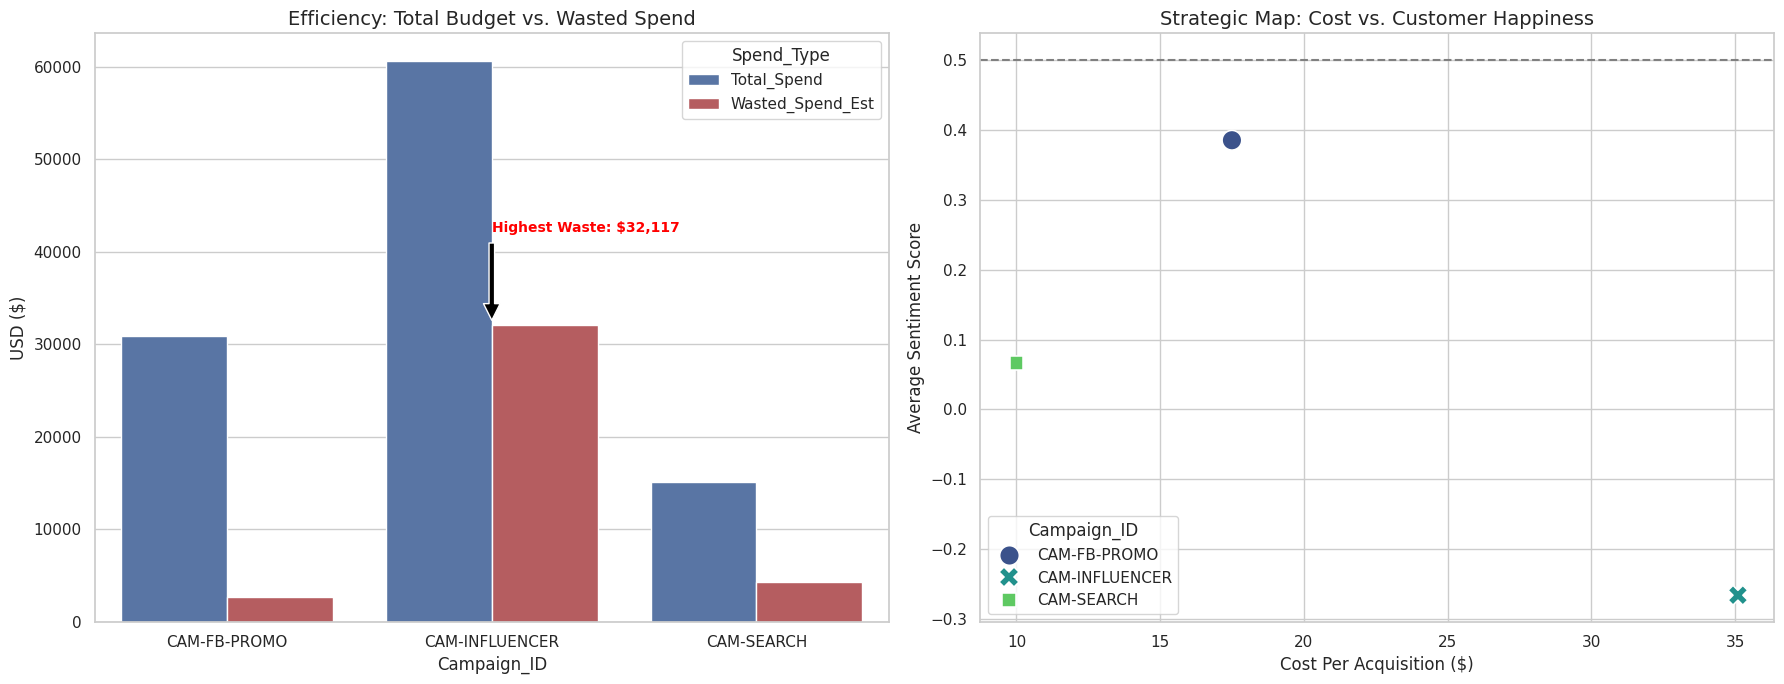

In [24]:
# Setup Dashboard (2 Charts side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# CHART A: Total Spend vs Wasted Spend (The original one)
plot_data = campaign_performance.melt(
    id_vars=['Campaign_ID'],
    value_vars=['Total_Spend', 'Wasted_Spend_Est'],
    var_name='Spend_Type', value_name='Amount_USD'
)

sns.barplot(ax=axes[0], x='Campaign_ID', y='Amount_USD', hue='Spend_Type', data=plot_data, palette=['#4c72b0', '#c44e52'])
axes[0].set_title('Efficiency: Total Budget vs. Wasted Spend', fontsize=14)
axes[0].set_ylabel('USD ($)')

# Annotate the worst campaign
max_waste = campaign_performance['Wasted_Spend_Est'].max()
axes[0].annotate(f'Highest Waste: ${max_waste:,.0f}',
             xy=(1, max_waste), xytext=(1, max_waste + 10000),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='red', fontweight='bold')

# CHART B: Sentiment vs. Cost Efficiency (NEW VISUAL)
# X-Axis: How expensive is the acquisition? Y-Axis: How happy are they?
sns.scatterplot(ax=axes[1], data=campaign_performance, x='Cost_Per_Review', y='Average_Sentiment',
                hue='Campaign_ID', s=200, palette='viridis', style='Campaign_ID')
axes[1].set_title('Strategic Map: Cost vs. Customer Happiness', fontsize=14)
axes[1].set_xlabel('Cost Per Acquisition ($)')
axes[1].set_ylabel('Average Sentiment Score')
axes[1].axhline(0.5, color='grey', linestyle='--') # Target Satisfaction Line

plt.tight_layout()
plt.show()